In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import scipy
import czifile

In [2]:
fullres = czifile.imread('../129S_94_tiles-2138.czi')

In [3]:
fullres = fullres.squeeze()

In [4]:
fullres.shape

(4, 9625, 9422)

In [84]:
f = czifile.CziFile('../129S_94_tiles-2138.czi')

In [87]:
with open('meta.xml', 'w') as w:
    w.write(f.metadata())

In [5]:
downres_factor = 8

In [6]:
lowres = skimage.transform.downscale_local_mean(fullres, (1, downres_factor, downres_factor))

In [8]:
def find_contour(channel):
    # Blur the image to ignore small lines and stuff
    blur = skimage.filters.gaussian(channel, sigma=10)

    # Separate fore- and background using otsu threshold
    th = skimage.filters.threshold_otsu(blur)
    thresholded = blur > th
    
    # fill holes
    filled = scipy.ndimage.binary_fill_holes(thresholded)
    
    # reduce size of contour at edges so that we are for sure inside the cutting
    erosion = 100
    eroded = skimage.morphology.binary_erosion(filled, np.ones((erosion, erosion)))
    
    # convert binary image to contour line
    contours = skimage.measure.find_contours(eroded, 0.5)
    assert len(contours) == 1
    return contours[0], eroded

contour, lowres_mask = find_contour(lowres[1])

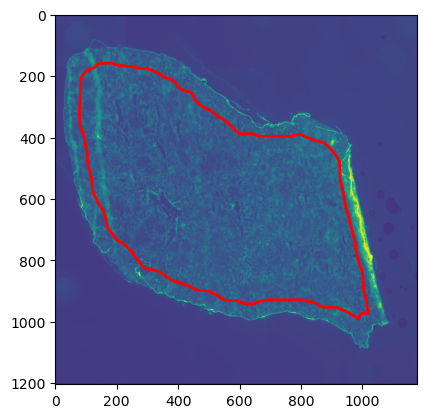

In [9]:
fig, ax = plt.subplots()
ax.imshow(lowres[1])
ax.plot(contour[:, 1], contour[:, 0], linewidth=2, c='r');

In [12]:
active_threshold = 1000

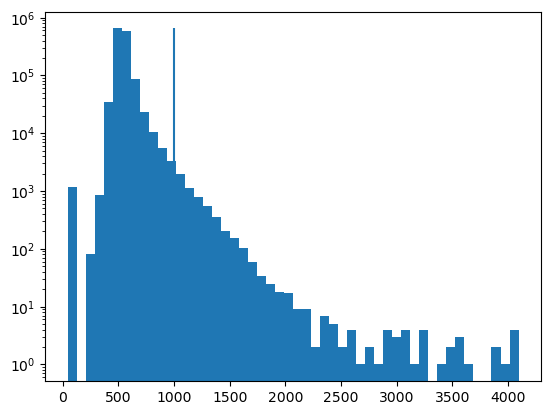

In [14]:
c, _, _ = plt.hist(lowres[3].flatten(), bins=50)
plt.yscale('log')
plt.vlines(active_threshold, ymin=0, ymax=c.max());

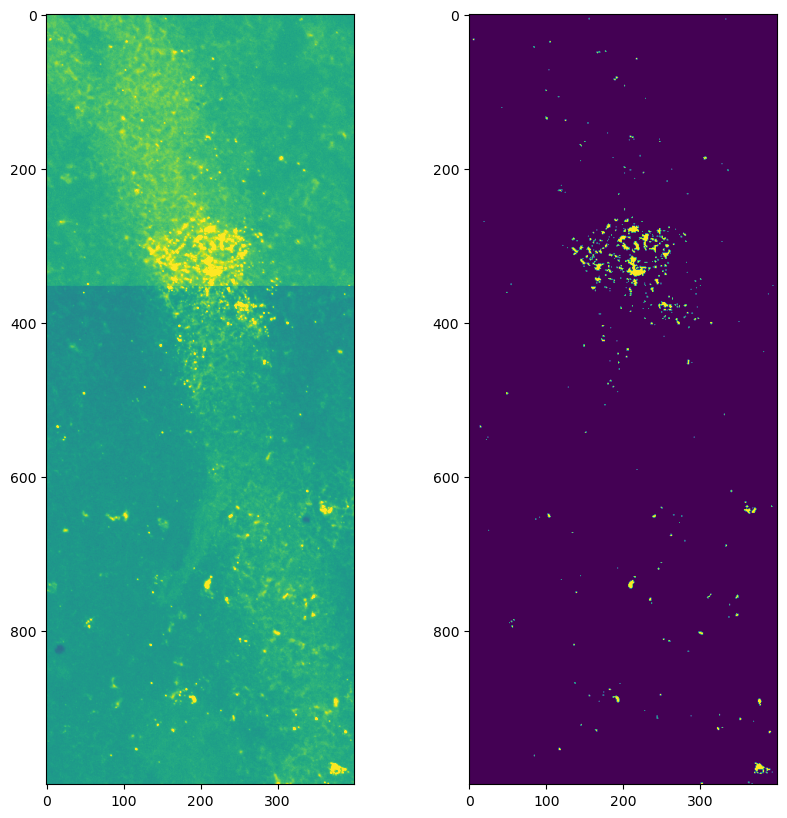

In [57]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 10))
segm = fullres[3, 1000:2000, 800:1200]
ax1.imshow(segm, clim=(0, 1000))
ax2.imshow(segm > active_threshold)

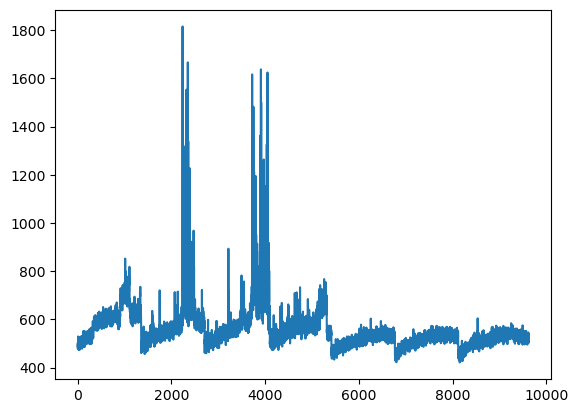

In [83]:
plt.plot(fullres[3, :, 800])

In [33]:
def upscale(image):
    # Upscale and cut to size (since original image was not perfectly divisible by 8)
    full_size = fullres[0].shape
    return skimage.transform.rescale(image, downres_factor)[:full_size[0], :full_size[1]]

In [41]:
def count_area(mask, image, threshold):
    total_area = np.count_nonzero(mask)
    active_area = np.count_nonzero((image > threshold) & mask)
    
    return total_area, active_area

In [43]:
total, active = count_area(lowres_mask, lowres[3], active_threshold)
active / total

0.00867567165668866

In [42]:
total, active = count_area(upscale(lowres_mask), fullres[3], active_threshold)
active / total

0.012494862888128854

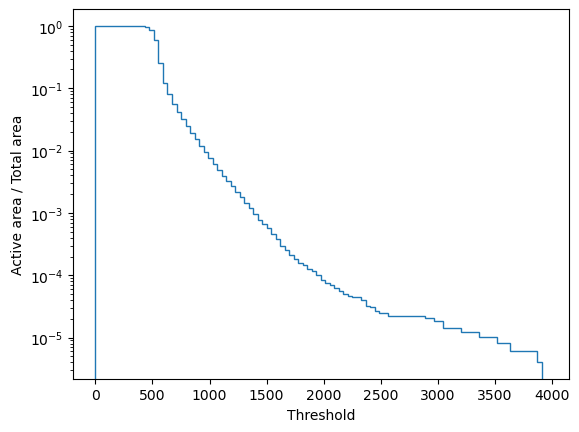

In [89]:
def count_area_hist(mask, image, min_threshold):
    total_area = np.count_nonzero(mask)
    masked = image * mask
    hist, bins = np.histogram(masked.flatten(), range=(min_threshold, masked.max()), bins=100)
    hist = np.cumsum(hist)
    hist = hist[-1] - hist
    hist = hist / total_area
    plt.stairs(hist, bins)
    plt.xlabel('Threshold')
    plt.ylabel('Active area / Total area')
    plt.yscale('log')
count_area_hist(lowres_mask, lowres[3], 0)

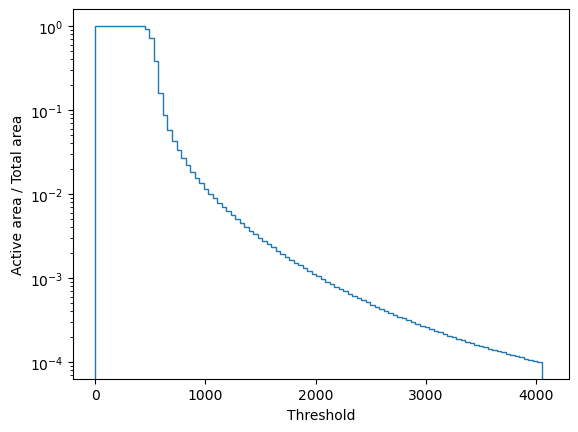

In [90]:
count_area_hist(upscale(lowres_mask), fullres[3], 0)